<h1>Locating with Healthsites.io Notebook - Liberia<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-Geob-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-Geob-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to Geob Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-Geob-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-Geob-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to Geob Adm 2</a></span></li><li><span><a href="#Match-orgunitlevel2-to-Geob-Adm-1" data-toc-modified-id="Match-orgunitlevel2-to-Geob-Adm-1-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Match orgunitlevel2 to Geob Adm 1</a></span></li></ul></li></ul></li></ul></div>

Version: April 22, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources of geo-located health facilities, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [1]:
import os
from datetime import datetime
import geopandas as gpd
import pandas as pd
from geopy.geocoders import Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
from os.path import join
from dotenv import load_dotenv, find_dotenv

# local imports
import geocoding_utils as gcu
import preprocessing_utils as ppu
import search_utils as ssu

In [2]:
iso3 = "LBR"
diso = "lr"
country = "Liberia"
input_dir = "/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/data"
input_filename = "preprocess_LBR_matches.csv" #"liberia2022-11-15.csv"
output_dir = join(input_dir, "output", iso3)
num_admin_levels = 2
num_org_levels = 5
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']

In [3]:
master_table = pd.read_csv(os.path.join(input_dir, input_filename), encoding='utf-8')
geob_arr = ppu.get_geoboundaries(num_admin_levels, iso3)

In [60]:
# Liberia-specific update
master_table['orgunitlevel5'] = master_table['organisationunitname']

In [61]:
len(master_table)

848

In [62]:
master_table.head(2)

,Unnamed: 0,index,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,orgunitlevel3_edit,adm2,orgunitlevel2_edit,adm1,orgunitlevel5
0,0,0,Liberia,Sinoe,Tarjuwon District,Gbason Town Clinic,DAmhVvbzEl6,Gbason Town Clinic,LR5GZ3,NaN,Tarjuwon,NaN,Sinoe,Sinoe,Gbason Town Clinic
1,1,4,Liberia,Margibi,Mambah-Kaba District,14 Military Hospital,oUPdjvJABX7,14 Military Hospital,LR0GW8,NaN,Mambah-Kaba,Mambah Kaba,Margibi,Margibi,14 Military Hospital


In [63]:
for org_lvl in range(2, num_org_levels+1):
    print(f"Unique Level {org_lvl}: {len(master_table[f'orgunitlevel{org_lvl}'].unique())}")


Unique Level 2: 15
Unique Level 3: 93
Unique Level 4: 846
Unique Level 5: 846


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.

In QGIS, I created centroids from the ways then merged it with the points.
DLH Note: I didn't have access to this merge, so am using the nodes.shp only, for proof of concept

https://healthsites.io/map?country=Liberia

In [64]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", country, f"{country}-node.shp"))
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()
nodes_io['name'] = nodes_io['name'].str.lower()
nodes_io.loc[:, "is_point"] = nodes_io.apply(lambda x: type(x.geometry)==Point, axis=1)

In [65]:
len(nodes_io.loc[~nodes_io.is_point])

0

In [66]:
len(nodes_io.loc[nodes_io.geometry.is_valid])==len(nodes_io)

True

In [67]:
records = master_table.copy()
records['geocoding_method'] = "None"
records['NAME'] = records[f'orgunitlevel{num_org_levels}'].str.lower()
ppu.remove_words(nodes_io, 'name', words_to_remove)
ppu.remove_words(records, 'NAME', words_to_remove)

for org_lev in range(4, num_org_levels+1):

    for idx, row in tqdm(records.iterrows()):

        # Check if there is another entry with location
        match, score = ssu.match_name(row.NAME, list(nodes_io['name']), 80)
    #     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)

        if score > 0:
            #print(row.NAME, match)
            matching_row = nodes_io.loc[nodes_io['name']==match].copy()
            res = matching_row.iloc[0]

            adm_idx = num_admin_levels
            for geobIdx in range(num_admin_levels-1, -1, -1): # reverse loop
                if not pd.isna(row[f"adm{adm_idx}"]):
                    geob = geob_arr[geobIdx]
                    adm = geob.loc[geob['shapeName'] == row[f'adm{adm_idx}']].copy()
                    if adm.contains(res.geometry).values[0] == True:
                        records.loc[idx, "longitude"] = res.geometry.x
                        records.loc[idx, "latitude"] = res.geometry.y
                        records.loc[idx, "geocoding_method"] = f"Location from Health Sites IO and within admin {adm_idx}"
                adm_idx -= 1


848it [00:12, 70.18it/s]
848it [00:12, 69.79it/s]


In [68]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,499,58.8%
None,349,41.2%


# Geocoding with APIs

In [1]:
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [70]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 3 names

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [71]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset[f"adm{num_admin_levels}"].isna()].copy()

In [72]:
len(records_subset)

211

In [73]:
records_subset.head(2)

,Unnamed: 0,index,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,orgunitlevel3_edit,adm2,orgunitlevel2_edit,adm1,orgunitlevel5,geocoding_method,NAME,longitude,latitude
2,2,6,Liberia,Montserrado,Commonwealth District,A Place of Rescue Health Clinic,SW1ahVurf5B,A Place of Rescue Health Clinic,LRUPY8,Located in Thinker Village,Commonwealth,Commonwealth,Montserrado,Montserrado,A Place of Rescue Health Clinic,None,a place of rescue,NaN,NaN
5,5,15,Liberia,Montserrado,St Paul River District,ACRES Community Clinic,SnP0w8xAPwu,ACRES Community Clinic,LR00N8,NaN,St Paul River,St. Paul River,Montserrado,Montserrado,ACRES Community Clinic,None,acres,NaN,NaN


In [17]:
smallest_geob = geob_arr[-1]
print(len(smallest_geob))
for adm_idx in range(num_admin_levels-1, -1, -1): # reverse order
    if adm_idx > 0:
        admNum = adm_idx+1
        print(f"Facility name and admin {admNum} names")
        for idx, row in records_subset.iterrows():
            adm = smallest_geob.loc[smallest_geob['shapeName'] == row[f'adm{admNum}']].copy()

            records = gcu.run_geocoding(idx, row, records, adm, ['NAME', f'adm{admNum}'], diso,
                                        geolocator_bing, geolocator_osm, geolocator_google)


        records_subset = records.loc[records.geocoding_method=="None"].copy()
        records_subset = records_subset.loc[~records_subset[f"adm{adm_idx}"].isna()].copy()
        if adm_idx -1 > 0:
            records_subset = records_subset.loc[~records_subset[f"adm{adm_idx-1}"].isna()].copy()
        print(f"Num not found: {len(records_subset)}")

136
Facility name and admin 2 names
Items: ['a place of rescue', 'Commonwealth']
Items: ['acres', 'St. Paul River']
Items: ['af russell', 'St. Paul River']
Items: ['agape', 'Sanniquellie Mahn']
Items: ['agape', 'Commonwealth']
Items: ['alfred f. kortio medical', 'Commonwealth']
Items: ['amusawyer', 'St. Paul River']
Items: ['anet mini', 'Commonwealth']
Items: ['balm in gilead', 'Commonwealth']
Items: ['barbour hill', 'Kakata']
Items: ['barclayville', 'Barclayville']
Items: ['bargblor', 'Cavala']
Items: ['beh town  (cavalla)', 'Cavala']
Items: ['behwan', 'Trenbo']
Items: ['beletanda', 'Sanoyeah']
Items: ["ben's town", 'Mambah Kaba']
Items: ['berh lombaye memorial', 'Gbehlay-Geh']
Items: ['besoa', 'Klay']
Items: ['bolloh new town', 'Dorbor']
Items: ['booker washington institute', 'Kakata']
Items: ['boye town', 'Mambah Kaba']
Items: ['boyee', 'Yarwein Mehnsonnoh']
Items: ['bracket christian', 'Todee']
Items: ['brown', 'Commonwealth']
Items: ['buah', 'Buah']
Items: ['carver mission', 'Comm

In [18]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,499,58.8%
NAME and adm2 query Bing,84,9.9%
NAME and adm2 query Google,23,2.7%
NAME and adm2 query OSM,37,4.4%
None,205,24.2%


## Orgunitlevel5 names

Geocode based on orgunitlevel 5 name.  
Check to make sure result falls within admin 3 polygon.  

In [19]:
records['NAME5'] = records['orgunitlevel5'].str.lower()
ppu.remove_words(records, 'NAME5', words_to_remove)

records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset[f"adm{num_admin_levels}"].isna()].copy()

In [30]:
admNum = num_admin_levels

for org_idx in range(num_org_levels, -1, -1): # reverse order
    if org_idx > 3:
        the_cols = ['NAME5', f'adm{admNum}'] if org_idx == 5 else ['NAME5', f'orgunitlevel{org_idx}']
        print(f"Geocoding for org level {org_idx}")
        orglev_df = records_subset[[f'orgunitlevel{org_idx}', 'NAME5', f'adm{admNum}', 'orgunitlevel1']].drop_duplicates().copy()
        print(f"Num recs at org level {org_idx}: {len(orglev_df)}")

        for idx, row in orglev_df.iterrows():

            adm = smallest_geob.loc[smallest_geob['shapeName'] == row[f'adm{admNum}']].copy()
            #print(len(adm))
            orglev_df = gcu.run_geocoding(idx, row, orglev_df, adm, the_cols, diso,
                              geolocator_bing, geolocator_osm, geolocator_google)
        print(orglev_df.geocoding_method.value_counts())

        for idx, row in tqdm(records_subset.iterrows()):
            if org_idx == num_org_levels:
                orglev_geocoded = orglev_df.loc[orglev_df['NAME5']==row['NAME5']].iloc[0]
                records.loc[idx, "longitude"] = orglev_geocoded.longitude
                records.loc[idx, "latitude"] = orglev_geocoded.latitude
                records.loc[idx, "geocoding_method"] = orglev_geocoded.geocoding_method
            else:
                if row.geocoding_method =="None":
                    cent = adm.geometry.representative_point().iloc[0]
                    records.loc[idx, "longitude"] = cent.x
                    records.loc[idx, "latitude"] = cent.y
                    records.loc[idx, "geocoding_method"] = "District centroid"

        records_subset = records.loc[records.geocoding_method=="None"].copy()
        records_subset = records_subset.loc[~records_subset[f"adm{admNum}"].isna()].copy()

Geocoding for org level 5
Num recs at org level 5: 67
Items: ['a place of rescue', 'Commonwealth']
Items: ['agape', 'Commonwealth']
Items: ['alfred f. kortio medical', 'Commonwealth']
Items: ['anet mini', 'Commonwealth']
Items: ['balm in gilead', 'Commonwealth']
Items: ['beh town  (cavalla)', 'Cavala']
Items: ['besoa', 'Klay']
Items: ['bolloh new town', 'Dorbor']
Items: ['brown', 'Commonwealth']
Items: ['carver mission', 'Commonwealth']
Items: ['comfort', 'Firestone']
Items: ['compassionate care', 'Commonwealth']
Items: ['confidence', 'Commonwealth']
Items: ['d h luo', 'Commonwealth']
Items: ["dolo's town", 'Firestone']
Items: ['dr. agnes varis', 'Commonwealth']
Items: ['e s grant mental', 'Commonwealth']
Items: ['el-shadah', 'Commonwealth']
Items: ['elwa', 'Commonwealth']
Items: ['esther  amos medical', 'Commonwealth']
Items: ['from god to man-ma-hawa', 'Commonwealth']
Items: ['garzon', 'Firestone']
Items: ['genesis care medical  annex 1 (breath of life )', 'Commonwealth']
Items: ["gl

67it [00:00, 1058.15it/s]

Geocoding for org level 4
Num recs at org level 4: 67
Items: ['a place of rescue', 'A Place of Rescue Health Clinic']


Items: ['agape', 'Agape Health Clinic']
Items: ['alfred f. kortio medical', 'Alfred F. Kortio Medical']
Items: ['anet mini', 'Anet Mini Community Clinic']
Items: ['balm in gilead', 'Balm In Gilead  Clinic']
Items: ['beh town  (cavalla)', 'Beh Town Clinic (Cavalla)']
Items: ['besoa', 'Besoa Clinic']
Items: ['bolloh new town', 'Bolloh New Town Clinic']
Items: ['brown', 'Brown Community Clinic']
Items: ['carver mission', 'Carver Mission Clinic']
Items: ['comfort', 'Comfort Health Center']
Items: ['compassionate care', 'Compassionate Care Clinic']
Items: ['confidence', 'Confidence Clinic']
Items: ['d h luo', 'D H Luo Community Clinic']
Items: ["dolo's town", "Dolo's Town Health Center"]
Items: ['dr. agnes varis', 'Dr. Agnes Varis Health Center']
Items: ['e s grant mental', 'E S Grant Mental Hospital']
Items: ['el-shadah', 'El-Shadah Clinic']
Items: ['elwa', 'ELWA Hospital']
Items: ['esther  amos medical', 'Esther  Amos Medical Clinic']
Items: ['from god to man-ma-hawa', 'From God to Man-Ma

67it [00:00, 1578.52it/s]


In [31]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,67,7.9%
Location from Health Sites IO and within admin 1,499,58.8%
NAME and adm2 query Bing,84,9.9%
NAME and adm2 query Google,23,2.7%
NAME and adm2 query OSM,37,4.4%
None,138,16.3%


## Admin 3  and admin 2 names

In [35]:
admin_lev = 2
for geob_idx in range(len(geob_arr)-1, -1, -1): # reverse order
    print(geob_idx)
    geob = geob_arr[geob_idx]
    records_subset = records.loc[records.geocoding_method=="None"].copy()
    records_subset = records_subset.loc[~records_subset[f"adm{admin_lev}"].isna()].copy()
    len(records_subset)

    orglev4_df = records_subset[['orgunitlevel4', f"adm{admin_lev}", 'orgunitlevel1']].drop_duplicates().copy()
    len(orglev4_df)

    for idx, row in tqdm(orglev4_df.iterrows()):
        adm2 = geob.loc[geob['shapeName'] == row[f"adm{admin_lev}"]].copy()
        orglev4_df = gcu.run_geocoding(idx, row, orglev4_df, adm2, ['orgunitlevel4', f"adm{admin_lev}"], diso,
                                       geolocator_bing, geolocator_osm, geolocator_google)

    for idx, row in tqdm(records_subset.iterrows()):
        orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]
        records.loc[idx, "longitude"] = orglev4_geocoded.longitude
        records.loc[idx, "latitude"] = orglev4_geocoded.latitude
        records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

    admin_lev -= 1

1


0it [00:00, ?it/s]
0it [00:00, ?it/s]


0


0it [00:00, ?it/s]

Items: ['Gbason Town Clinic', 'Sinoe']


1it [00:00,  1.14it/s]

Items: ['AFRO-Medical Communiy Clinic', 'Montserrado']


2it [00:01,  1.97it/s]

Items: ['Ahmadiyya Mission Muslim Clinic', 'Montserrado']


3it [00:01,  2.15it/s]

Items: ['Ahmadiyya Muslim Mission Clinic', 'Montserrado']


4it [00:02,  2.10it/s]

Items: ['Albert Steward Medical Clinic', 'Montserrado']


5it [00:02,  1.75it/s]

Items: ['Amagashie Clinic', 'Montserrado']


6it [00:03,  2.18it/s]

Items: ['AMEU Clinic', 'Montserrado']


7it [00:03,  1.96it/s]

Items: ['Annur (The Light) Clinic', 'Montserrado']


8it [00:04,  1.86it/s]

Items: ['Aspen Medical International', 'Montserrado']


9it [00:04,  2.00it/s]

Items: ['Aunty Gloria Medical Clinic', 'Montserrado']


10it [00:05,  2.04it/s]

Items: ['B.T.C Clinic', 'Montserrado']


11it [00:07,  1.04s/it]

Items: ['Barconnie Clinic', 'Grand Bassa']


12it [00:07,  1.27it/s]

Items: ['Beindin Clinic', 'Nimba']


13it [00:08,  1.42it/s]

Items: ['Belle Baloma Clinic', 'Montserrado']


14it [00:08,  1.51it/s]

Items: ['Bishop Darlington  Clinic', 'Montserrado']


15it [00:09,  1.53it/s]

Items: ['Blessing Maternity Clinic', 'Montserrado']


16it [00:09,  1.82it/s]

Items: ['Breath Of Life(Central)', 'Montserrado']


17it [00:10,  1.76it/s]

Items: ['Bunadin Clinic', 'Nimba']


18it [00:10,  2.06it/s]

Items: ['Carter Center LMA Market School Based Clinic', 'Montserrado']


19it [00:11,  1.86it/s]

Items: ['Central Matadi Dweh Memorial Clinic', 'Montserrado']


20it [00:11,  1.78it/s]

Items: ['Cheboken Clinic', 'River Gee']


21it [00:12,  2.17it/s]

Items: ['City View Comm. Clinic', 'Montserrado']


22it [00:12,  2.07it/s]

Items: ['Clini Lab', 'Montserrado']


23it [00:13,  1.91it/s]

Items: ['Daqmow Clinic', 'Montserrado']


24it [00:13,  1.94it/s]

Items: ['Devine Touch Maternal and Child Health Clinic', 'Montserrado']


25it [00:14,  1.94it/s]

Items: ['Diagnostic Rescue International Clinic', 'Montserrado']


26it [00:14,  2.01it/s]

Items: ['Divine Wonder Community Clinic', 'Montserrado']


27it [00:15,  1.98it/s]

Items: ['Dniyama Out Patient Clinic', 'Montserrado']


28it [00:15,  2.03it/s]

Items: ['Dorbor Clinic', 'Rivercess']


29it [00:16,  1.96it/s]

Items: ['Dr. Alexander P. Tokpah Clinic', 'Sinoe']


30it [00:16,  1.88it/s]

Items: ['Dr. Bob Community Clinic', 'Montserrado']


31it [00:17,  1.94it/s]

Items: ['Duo Town Clinic', 'Nimba']


32it [00:17,  1.91it/s]

Items: ['Earlbert Medical Services, INC', 'Montserrado']


33it [00:18,  2.16it/s]

Items: ['Faith Medical & Laboratory Clinic', 'Montserrado']


34it [00:18,  2.12it/s]

Items: ['Family Medical Clinic', 'Montserrado']


35it [00:19,  1.99it/s]

Items: ['Father James Lee Maternity Clinic', 'Montserrado']


36it [00:19,  2.03it/s]

Items: ['Fidelity Health Care Services Inc.', 'Montserrado']


37it [00:20,  1.91it/s]

Items: ['Firehouse Clinic (John S. Butler Clinic) II', 'Montserrado']


38it [00:20,  1.71it/s]

Items: ['Fountain of Life Clinic', 'Montserrado']


39it [00:21,  1.99it/s]

Items: ['Genesis Healthcare Medical Clinic', 'Montserrado']


40it [00:21,  2.05it/s]

Items: ['Gloring Health Clinic', 'Montserrado']


41it [00:22,  1.84it/s]

Items: ['Gmomaken Clinic', 'River Gee']


42it [00:22,  2.16it/s]

Items: ['God Grace', 'Montserrado']


43it [00:23,  2.06it/s]

Items: ['Grace A Reeves Baptist Clinic', 'Montserrado']


44it [00:23,  2.21it/s]

Items: ['Haja Kadiatu Sherif Memorial Clinic', 'Montserrado']


46it [00:24,  2.02it/s]

Items: ['Hope For Women Clinic', 'Montserrado']
Items: ['Hydro MERCI Clinic', 'Montserrado']


47it [00:25,  1.96it/s]

Items: ['Iron Factory Clinic', 'Montserrado']


48it [00:25,  2.07it/s]

Items: ['Islamic Medical Surgical Clinic', 'Montserrado']


49it [00:26,  1.83it/s]

Items: ['Jacksonville Clinic', 'Sinoe']


50it [00:26,  1.88it/s]

Items: ['JAHMALE Medical Solutions', 'Montserrado']


51it [00:27,  2.05it/s]

Items: ['JF Kennedy Medical Center', 'Montserrado']


52it [00:27,  2.09it/s]

Items: ['Jobeta Clinic', 'Montserrado']


53it [00:28,  1.98it/s]

Items: ['Joelu Maternity Clinic', 'Montserrado']


54it [00:28,  1.89it/s]

Items: ['Joseph Boakai Clinic', 'Montserrado']


55it [00:29,  2.04it/s]

Items: ['Julius Roger Maternity Clinic', 'Montserrado']


56it [00:29,  1.97it/s]

Items: ['JY Memorial Clinic', 'Montserrado']


57it [00:30,  1.91it/s]

Items: ['Kenneh Medical Clinic', 'Montserrado']


58it [00:30,  2.04it/s]

Items: ['Kpallah Clinic', 'Nimba']


59it [00:31,  1.90it/s]

Items: ['Leonell Gulf Community Clinic', 'Montserrado']


60it [00:31,  2.06it/s]

Items: ['Liberia Albino Society Clinic', 'Montserrado']


61it [00:32,  1.89it/s]

Items: ['Liberia Coast Guard Clinic', 'Montserrado']


62it [00:33,  1.88it/s]

Items: ['Liberia Government Hospital (Buchanan)', 'Grand Bassa']


63it [00:33,  2.26it/s]

Items: ['Liberia National Police Clinic', 'Montserrado']


64it [00:33,  1.96it/s]

Items: ['Liberia National Red Cross Clinic', 'Montserrado']


65it [00:34,  1.96it/s]

Items: ['M. Watta Kamara Medical Clinic', 'Montserrado']


66it [00:34,  1.96it/s]

Items: ['Ma -Watta Medical & Eye', 'Montserrado']


67it [00:35,  2.05it/s]

Items: ['Ma- Bea Community Clinic', 'Montserrado']


68it [00:36,  1.92it/s]

Items: ['Ma- Yanlla Clinic', 'Montserrado']


69it [00:36,  2.06it/s]

Items: ['Ma-Esther Clinic', 'Montserrado']


70it [00:36,  2.16it/s]

Items: ['Maggie Medical Clinic', 'Montserrado']


71it [00:37,  1.98it/s]

Items: ['Marie Thomas clinic', 'Montserrado']


72it [00:37,  1.96it/s]

Items: ['MASHCO Medical Clinic', 'Montserrado']


73it [00:38,  1.84it/s]

Items: ['Matadi City Clinic', 'Montserrado']


74it [00:38,  1.99it/s]

Items: ['Medical Consultants Associates (MALAG) Clinic', 'Montserrado']


75it [00:39,  2.14it/s]

Items: ['Medlink International (Kassas) Clinic', 'Montserrado']


76it [00:40,  1.93it/s]

Items: ['Mercy International Clinic', 'Montserrado']


77it [00:40,  2.09it/s]

Items: ['Mercy Medical Clinic', 'Montserrado']


78it [00:40,  2.08it/s]

Items: ['Ministry of Foreign Affairs Clinic & Medical Services', 'Montserrado']


79it [00:41,  2.00it/s]

Items: ['Ministry of Public Works Clinic', 'Montserrado']


80it [00:42,  1.75it/s]

Items: ['Monrovia Central Prison Clinic', 'Montserrado']


81it [00:42,  2.02it/s]

Items: ['Mother and Child Clinic', 'Montserrado']


82it [00:42,  2.06it/s]

Items: ['National TB & Leprosy Hospital', 'Montserrado']


83it [00:43,  2.27it/s]

Items: ['Niful Clinic', 'Grand Kru']


84it [00:43,  2.06it/s]

Items: ['North Road Merci Clinic', 'Montserrado']


85it [00:44,  1.81it/s]

Items: ['Old Road Community Clinic', 'Montserrado']


86it [00:45,  1.63it/s]

Items: ['P K Nyansaiye Medical Clinic', 'Montserrado']


87it [00:45,  2.02it/s]

Items: ['Payee Community Clinic', 'Nimba']


88it [00:46,  1.99it/s]

Items: ['Peace Clinic', 'Montserrado']


89it [00:46,  2.15it/s]

Items: ['Planned Parenthood Association', 'Montserrado']


90it [00:47,  1.75it/s]

Items: ['Potter Care Clinic', 'Montserrado']


91it [00:47,  1.80it/s]

Items: ['Praise Medico Surgical Clinic', 'Grand Bassa']


92it [00:48,  1.64it/s]

Items: ['Prestige Medical Clinic', 'Montserrado']


93it [00:49,  1.58it/s]

Items: ['R. B. Clinic', 'Montserrado']


94it [00:52,  1.49s/it]

Items: ['Rambow Clinic', 'Montserrado']


95it [00:53,  1.17s/it]

Items: ['Rapha Medical Clinic', 'Montserrado']


96it [00:53,  1.00it/s]

Items: ['Raphal Clinic', 'Montserrado']


97it [00:54,  1.22it/s]

Items: ['Redemption Hospital', 'Montserrado']


98it [00:54,  1.36it/s]

Items: ['Renaissance Maternity Clinic', 'Montserrado']


99it [00:55,  1.51it/s]

Items: ['Roselyn Toe Massaquoi Clinic', 'Sinoe']


100it [00:55,  1.61it/s]

Items: ['Saclepea Dorcus Mantor Clinic', 'Nimba']


101it [00:56,  1.47it/s]

Items: ['Safe Zone Community Clinic', 'Montserrado']


102it [00:56,  1.85it/s]

Items: ['Samson Urgent Care Center', 'Montserrado']


103it [00:57,  1.78it/s]

Items: ['Samuel David Medical Clinic (SDMC)', 'Grand Bassa']


104it [00:57,  1.83it/s]

Items: ['Sarah Smith Maternity Clinic', 'Montserrado']


105it [00:58,  1.86it/s]

Items: ['Sass Town Health Center', 'Grand Kru']


106it [00:58,  1.88it/s]

Items: ['SDA Cooper Memorial Hospital', 'Montserrado']


107it [00:59,  2.13it/s]

Items: ['Sekou Ahmadu Camara Memorial and Dental Clinic', 'Montserrado']


108it [00:59,  1.95it/s]

Items: ['Sister Barbara Ann Health Center', 'Montserrado']


109it [01:00,  1.82it/s]

Items: ['Sobo Community Clinic', 'Grand Kru']


110it [01:00,  2.09it/s]

Items: ['SOS Clinic', 'Montserrado']


111it [01:01,  2.11it/s]

Items: ["St Joseph's Catholic Hospital", 'Montserrado']


112it [01:01,  2.18it/s]

Items: ['St. Joseph Catholic Health Center', 'Montserrado']


113it [01:02,  1.77it/s]

Items: ['Stamar Karmo Clinic', 'Montserrado']


114it [01:02,  2.06it/s]

Items: ['Stanko Maternity Clinic', 'Montserrado']


115it [01:03,  2.19it/s]

Items: ['Steven Tolbert Memorial Hospital (ArcelorMittal)', 'Grand Bassa']


116it [01:03,  1.99it/s]

Items: ['Suzan & Sonnie Clinic', 'Montserrado']


117it [01:04,  2.14it/s]

Items: ['The Good Will Clinic Annex II', 'Montserrado']


118it [01:04,  1.89it/s]

Items: ['Third Rock Clinic', 'Montserrado']


119it [01:05,  2.13it/s]

Items: ['Thumbs Up Community Clinic', 'Montserrado']


120it [01:05,  1.77it/s]

Items: ['Trojen Medical Center', 'Montserrado']


121it [01:06,  2.06it/s]

Items: ['Tubman High School Based Clinic', 'Montserrado']


122it [01:06,  1.89it/s]

Items: ['Tubmanville Clinic (Buchanan)', 'Grand Bassa']


123it [01:07,  2.03it/s]

Items: ['ULIC Bahn Mission Clinic', 'Nimba']


124it [01:07,  2.15it/s]

Items: ['UN Clinic, Monrovia', 'Montserrado']


125it [01:08,  1.82it/s]

Items: ['Vezely Hope Clinic', 'Montserrado']


126it [01:08,  2.08it/s]

Items: ['Vicembien Clinic', 'Montserrado']


127it [01:09,  1.90it/s]

Items: ['Weato Memorial Clinic', 'Nimba']


128it [01:09,  2.10it/s]

Items: ['Wiah Town Clinic', 'Sinoe']


129it [01:10,  1.89it/s]

Items: ['Wonjah Smith Memorial Clinic', 'Montserrado']


130it [01:10,  2.12it/s]

Items: ['Wroto Town Clinic', 'Montserrado']


131it [01:11,  2.07it/s]

Items: ['YAWEH Clinic', 'Montserrado']


132it [01:11,  1.98it/s]

Items: ['Zobo Medical Clinic', 'Montserrado']


133it [01:12,  1.96it/s]

Items: ['National Port Authority Clinic', 'Montserrado']


134it [01:12,  1.87it/s]

Items: ['B.W. Payne School Based Clinic', 'Montserrado']


135it [01:13,  2.01it/s]

Items: ['Chugbor Community Clinic', 'Montserrado']


136it [01:13,  1.99it/s]

Items: ['Twelve Street Community Curative Clinic', 'Montserrado']


137it [01:14,  2.00it/s]

Items: ['Fatima Clinic', 'Montserrado']


138it [01:14,  1.84it/s]
138it [00:00, 1350.36it/s]


In [36]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,67,7.9%
Location from Health Sites IO and within admin 1,499,58.8%
NAME and adm2 query Bing,84,9.9%
NAME and adm2 query Google,23,2.7%
NAME and adm2 query OSM,37,4.4%
None,1,0.1%
orgunitlevel4 and adm1 query Bing,103,12.1%
orgunitlevel4 and adm1 query Google,7,0.8%
orgunitlevel4 and adm1 query OSM,27,3.2%


# Map and save results

In [37]:
results = records.copy()

In [38]:
results.geocoding_method.unique()

array(['orgunitlevel4 and adm1 query Google',
       'Location from Health Sites IO and within admin 1',
       'District centroid', 'NAME and adm2 query Bing',
       'NAME and adm2 query Google', 'orgunitlevel4 and adm1 query Bing',
       'orgunitlevel4 and adm1 query OSM', 'NAME and adm2 query OSM',
       'None'], dtype=object)

In [39]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel6 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel6 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME and adm1 query Bing", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query OSM", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query Google", "geocoding_method"] = "orgunitlevel6 and adm1 query"

# facility name and adm 3
results.loc[results.geocoding_method=="NAME5 and adm3 query Bing", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query OSM", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query Google", "geocoding_method"] = "orgunitlevel5 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME5 and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME5 and adm1 query Bing", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query OSM", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query Google", "geocoding_method"] = "orgunitlevel5 and adm1 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Bing", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query OSM", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Google", "geocoding_method"] = "orgunitlevel4 and adm1 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [40]:
gcu.report_geocoding(results)

,count,pct
geocoding_method,,
Adm3 centroid,67,7.9%
Location from Health Sites IO and within admin 1,499,58.8%
None,1,0.1%
orgunitlevel4 and adm1 query,137,16.2%
orgunitlevel6 and adm2 query,144,17.0%


In [41]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

In [75]:
from matplotlib_scalebar.scalebar import ScaleBar

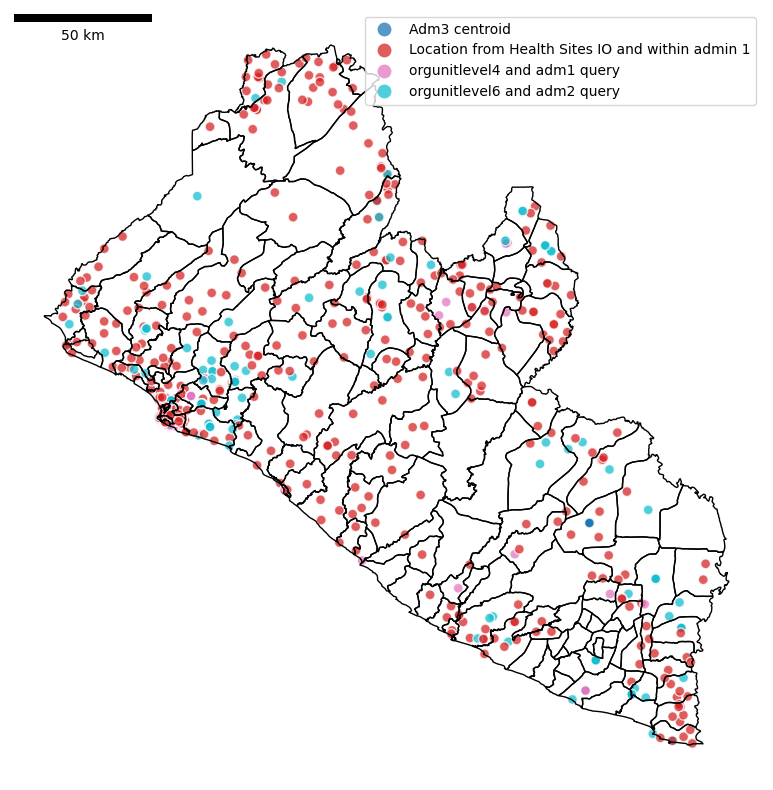

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
smallest_geob.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
scalebar = ScaleBar(60000, location="upper left") # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
#ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
plt.show()

## Join attributes from adminsitrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [48]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [49]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [50]:
len(records_subset)

1

In [51]:
for gIdx in range(len(geob_arr)-1, -1, -1):
    gNum = gIdx +1
    print(gIdx)

    geob = geob_arr[gIdx]
    results2 = gpd.sjoin(results2, geob[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
    results2.drop('index_right', axis=1, inplace=True)
    results2.rename(
        columns={
            'shapeName': f'geob_adm{gNum}',
            'shapeID': f'geob_adm{gNum}_id',
        }, inplace=True)

1
0


In [52]:
for gIdx in range(len(geob_arr)-1, -1, -1):
    gNum = gIdx +1
    print(results2[f"geob_adm{gNum}"].isna().sum())
    results2.rename(
        columns={
            f'adm{gNum}': f'fuzzy_match_adm{gNum}'
        }, inplace=True)

0
0


In [57]:
results_final = results2.copy()

In [59]:
ts = datetime.now().strftime("%m.%d.%y")
results_final.to_csv(join(output_dir, f"{iso3}_geocoding_{ts}.csv"))
results_final.to_file(join(output_dir, f"{iso3}_geocoding_{ts}.json"), driver="GeoJSON")